# L4: Multimodal Retrieval Augmented Generation (MM-RAG)

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Kernel Starting)</code>:</b> This notebook takes about 30 seconds to be ready to use. You may start and watch the video while you wait.</p>

>In this lesson you'll learn how to leverage Weaviate and Google Gemini Pro Vision to carry out a simple multimodal RAG workflow.

* In this classroom, the libraries have been already installed for you.
* If you would like to run this code on your own machine, you need to install the following:
```
    !pip install -U weaviate-client
    !pip install google-generativeai
```

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Setup
### Load environment variables and API keys

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

EMBEDDING_API_KEY = os.getenv("EMBEDDING_API_KEY")
GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")

> Note: learn more about [GOOGLE_API_KEY](https://ai.google.dev/) to run it locally.

### Connect to Weaviate

In [3]:
import weaviate

client = weaviate.connect_to_embedded(
    version="1.24.4",
    environment_variables={
        "ENABLE_MODULES": "backup-filesystem,multi2vec-palm",
        "BACKUP_FILESYSTEM_PATH": "/home/jovyan/work/backups",
    },
    headers={
        "X-PALM-Api-Key": EMBEDDING_API_KEY,
    }
)

client.is_ready()

Started /home/jovyan/.cache/weaviate-embedded: process ID 79


{"action":"startup","default_vectorizer_module":"none","level":"info","msg":"the default vectorizer modules is set to \"none\", as a result all new schema classes without an explicit vectorizer setting, will use this vectorizer","time":"2024-07-10T19:34:58Z"}
{"action":"startup","auto_schema_enabled":true,"level":"info","msg":"auto schema enabled setting is set to \"true\"","time":"2024-07-10T19:34:58Z"}
{"level":"info","msg":"No resource limits set, weaviate will use all available memory and CPU. To limit resources, set LIMIT_RESOURCES=true","time":"2024-07-10T19:34:58Z"}
{"action":"grpc_startup","level":"info","msg":"grpc server listening at [::]:50050","time":"2024-07-10T19:34:58Z"}
{"action":"restapi_management","level":"info","msg":"Serving weaviate at http://127.0.0.1:8079","time":"2024-07-10T19:34:58Z"}


True

{"action":"telemetry_push","level":"info","msg":"telemetry started","payload":"\u0026{MachineID:596b185e-aee9-498f-9d57-9f2f956704bf Type:INIT Version:1.24.4 Modules:backup-filesystem,multi2vec-palm NumObjects:0 OS:linux Arch:amd64}","time":"2024-07-10T19:34:59Z"}


### Restore 13k+ prevectorized resources

In [4]:
client.backup.restore(
    backup_id="resources-img-and-vid",
    include_collections="Resources",
    backend="filesystem"
)

# It can take a few seconds for the "Resources" collection to be ready.
# We add 5 seconds of sleep to make sure it is ready for the next cells to use.
import time
time.sleep(5)

{"action":"try_restore","backend":"filesystem","backup_id":"resources-img-and-vid","level":"info","msg":"","time":"2024-07-10T19:35:06Z","took":1206833}
{"level":"info","msg":"Completed loading shard resources_YR4XdMe3ODX3 in 6.488037ms","time":"2024-07-10T19:35:07Z"}
{"action":"restore","backup_id":"resources-img-and-vid","class":"Resources","level":"info","msg":"successfully restored","time":"2024-07-10T19:35:07Z"}
{"action":"restore","backup_id":"resources-img-and-vid","level":"info","msg":"backup restored successfully","time":"2024-07-10T19:35:07Z"}
{"action":"hnsw_vector_cache_prefill","count":16062,"index_id":"main","level":"info","limit":1000000000000,"msg":"prefilled vector cache","time":"2024-07-10T19:35:07Z","took":164053826}
{"action":"restore","backup_id":"resources-img-and-vid","level":"info","msg":"coordinator: backup restored successfully","time":"2024-07-10T19:35:08Z"}


### Preview data count

In [5]:
from weaviate.classes.aggregate import GroupByAggregate

resources = client.collections.get("Resources")

response = resources.aggregate.over_all(
    group_by=GroupByAggregate(prop="mediaType")
)

# print rounds names and the count for each
for group in response.groups:
    print(f"{group.grouped_by.value} count: {group.total_count}")

image count: 13394
video count: 200


## Multimodal RAG

### Step 1 – Retrieve content from the database with a query

In [6]:
from IPython.display import Image
from weaviate.classes.query import Filter

def retrieve_image(query):
    resources = client.collections.get("Resources")
# ============
    response = resources.query.near_text(
        query=query,
        filters=Filter.by_property("mediaType").equal("image"), # only return image objects
        return_properties=["path"],
        limit = 1,
    )
# ============
    result = response.objects[0].properties
    return result["path"] # Get the image path

### Run image retrieval

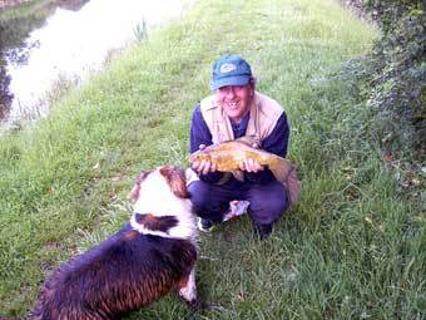

In [7]:
# Try with different queries to retreive an image
img_path = retrieve_image("fishing with my buddies")
display(Image(img_path))

<p style="background-color:#fff6ff; padding:15px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px"> 💻 &nbsp; <b>Access Files and Helper Functions:</b> To access the files for this notebook, 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>. For more help, please see the <em>"Appendix - Tips and Help"</em> Lesson.</p>


### Step 2 - Generate a description of the image

In [8]:
import google.generativeai as genai
from google.api_core.client_options import ClientOptions

# Set the Vision model key
genai.configure(
        api_key=GOOGLE_API_KEY,
        transport="rest",
        client_options=ClientOptions(
            api_endpoint=os.getenv("GOOGLE_API_BASE"),
        ),
)

In [9]:
# Helper function
import textwrap
import PIL.Image
from IPython.display import Markdown, Image

def to_markdown(text):
    text = text.replace("•", "  *")
    return Markdown(textwrap.indent(text, "> ", predicate=lambda _: True))

def call_LMM(image_path: str, prompt: str) -> str:
    img = PIL.Image.open(image_path)

    model = genai.GenerativeModel("gemini-pro-vision")
    response = model.generate_content([prompt, img], stream=True)
    response.resolve()

    return to_markdown(response.text)    

### Run vision request

In [10]:
call_LMM(img_path, "Please describe this image in detail.")

>  The image shows a man kneeling on the grassy bank of a river. He is wearing a green hat and a khaki vest. He is holding a large fish in his hands. The fish is golden brown in color and has a long, pointed snout. The man is smiling and looking down at the fish. There is a dog standing next to the man. The dog is black and white and has a long, shaggy coat. The dog is looking up at the fish. In the background, there is a narrow river with a small weir.

> Note: Please be aware that the output from the previous cell may differ from what is shown in the video. This variation is normal and should not cause concern.

## All together

In [11]:
def mm_rag(query):
    # Step 1 - retrieve an image – Weaviate
    SOURCE_IMAGE = retrieve_image(query)
    display(Image(SOURCE_IMAGE))
#===========

    # Step 2 - generate a description - GPT4
    description = call_LMM(SOURCE_IMAGE, "Please describe this image in detail.")
    return description

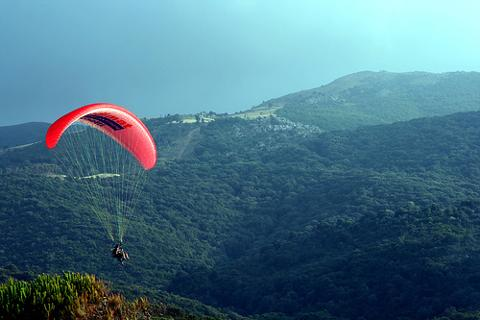

>  A paraglider is flying over a lush green mountain. The paraglider is red and white, and the mountain is covered in trees. The sky is blue and there are some clouds in the distance. The paraglider is flying at a high altitude, and the mountain is in the foreground. The image is taken from a low angle, and the paraglider is in the center of the frame.

In [12]:
# Call mm_rag function
mm_rag("paragliding through the mountains")

In [13]:
# Remember to close the weaviate instance
client.close()

{"action":"restapi_management","level":"info","msg":"Shutting down... ","time":"2024-07-10T19:36:23Z"}
{"action":"restapi_management","level":"info","msg":"Stopped serving weaviate at http://127.0.0.1:8079","time":"2024-07-10T19:36:23Z"}
{"action":"telemetry_push","level":"info","msg":"telemetry terminated","payload":"\u0026{MachineID:596b185e-aee9-498f-9d57-9f2f956704bf Type:TERMINATE Version:1.24.4 Modules:backup-filesystem,multi2vec-palm NumObjects:13594 OS:linux Arch:amd64}","time":"2024-07-10T19:36:24Z"}


### Try it yourself! 

Run the cells above selecting another image from the database and generate a description for it!